In [1]:
from pygmo import hypervolume
import csv
import statistics
import numpy as np
import operator as op
from functools import reduce
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

In [2]:
#### Modified from Pau's code
def compute_pareto_front(population):
    pop_size = len(population)
    obj_num = 2

    domination_counter = [0] * pop_size

    for i in range(pop_size):
        for j in range(i+1, pop_size):
            # check each objective for dominance
            dominate = [0] * obj_num
            for k in range(obj_num):
                if population[i][k] > population[j][k]:
                    dominate[k] = 1
                elif population[i][k] < population[j][k]:
                    dominate[k] = -1
            if -1 not in dominate and 1 in dominate:
                domination_counter[i] += 1
            elif -1 in dominate and 1 not in dominate:
                domination_counter[j] += 1

    pareto_solutions = []
    for i in range(len(domination_counter)):
        if domination_counter[i] == 0:
            pareto_solutions.append(population[i])
    return pareto_solutions

def compute_hv(population):
    array_archs = np.zeros((len(population), 2))
    for i in range(len(population)):
        array_archs[i] = population[i]
    hv_object = hypervolume(array_archs)
    hv = hv_object.compute([1.1,1.1])/1.1**2
    return hv

In [3]:
#### Useful functions and parameter defintions
nfe_interval = 50
    
def nchoosek(n,k):
    k = min(k, n-k)
    num = reduce(op.mul, range(n,n-k,-1), 1)
    den = reduce(op.mul, range(1,k+1), 1)
    return num/den
    
def get_true_objectives(true_obj1_array, true_obj2_array, index):
    return true_obj1_array[index], true_obj2_array[index]

def get_feasibility_score(feas_array, index):
    return feas_array[index]

def get_connectivity_score(conn_array, index):
    return conn_array[index]

def get_stiffness_ratio(stiffrat_array, index):
    return stiffrat_array[index]

def get_partcoll_score(partcoll_array, index):
    return partcoll_array[index]

def get_nodprop_score(nodprop_array, index):
    return nodprop_array[index]

def get_orientation_score(orient_array, index):
    return orient_array[index]

def get_design(design_array, index):
    return design_array[index]

def find_last_index(val,search_list):
    return len(search_list) - search_list[::-1].index(val) - 1

def find_closest_index(val,search_list):
    val_diff = np.array(search_list) - val
    closest_index = np.argmin(np.abs(val_diff))
    return closest_index

In [4]:
#### Determine csv filepath from given case type
def get_csv_filepath(partcoll_constrained, nodprop_constrained, orient_constrained, fib_stiff, optim_problem2, read_constrad, run_number):
    # partcoll_constrained = [int_pen, AOS, bias_init, ACH] boolean array
    # nodprop_constrained = [int_pen, AOS, bias_init, ACH] boolean array
    # orient_constrained = [int_pen, AOS, bias_init, ACH] boolean array
    # optim_problem2 - boolean to signify reading of optimization problem 2 data
    # read_constrad - boolean to signify reading of constant radii or variable radii data
    
    filepath = 'C:\\SEAK Lab\\SEAK Lab Github\\KD3M3\\Truss_AOS\\result\\'
    methods = ['Int Pen','AOS','Bias Init','ACH']
    if (partcoll_constrained[1] or nodprop_constrained[1] or orient_constrained[1]):
        filename = 'AOSMOEA_emoea_'
    else:
        filename = 'EpsilonMOEA_emoea_'
        
    if optim_problem2:
        filepath_prob = 'OA run data - optimization problem 2\\'
        if read_constrad:
            filename_prob = '_prob2'
        else:
            filename_prob = ''
    else:
        filepath_prob = 'OA run data - optimization problem 1\\'
        filename_prob = ''
        
    if read_constrad:
        filepath_constrad = 'Constant Radii\\'
    else:
        filepath_constrad = 'Variable Radii\\'
        
    filepath2 = ''
    filename2 = ''
    constr_count = 0
    for i in range(4):
        if(partcoll_constrained[i] and nodprop_constrained[i] and (not orient_constrained[i])):
            constrained = methods[i] + ' - PartColl and NodalProp\\'
            filename_snippet = 'pncon' + str(i) + '_'
        elif(partcoll_constrained[i] and (not nodprop_constrained[i]) and (not orient_constrained[i])):
            constrained = methods[i] + ' - PartColl\\'
            filename_snippet = 'pcon' + str(i) + '_'
        elif((not partcoll_constrained[i]) and nodprop_constrained[i] and (not orient_constrained[i])):
            constrained = methods[i] + ' - NodalProp\\'    
            filename_snippet = 'ncon' + str(i) + '_'
        elif((not partcoll_constrained[i]) and (not nodprop_constrained[i]) and orient_constrained[i]):
            constrained = methods[i] + ' - Orientation\\'    
            filename_snippet = 'ocon' + str(i) + '_'
        elif(partcoll_constrained[i] and (not nodprop_constrained[i]) and orient_constrained[i]):
            constrained = methods[i] + ' - PartColl and Orientation\\'    
            filename_snippet = 'pocon' + str(i) + '_'
        elif((not partcoll_constrained[i]) and nodprop_constrained[i] and orient_constrained[i]):
            constrained = methods[i] + ' - NodalProp and Orientation\\'    
            filename_snippet = 'nocon' + str(i) + '_'
        elif(partcoll_constrained[i] and nodprop_constrained[i] and orient_constrained[i]):
            constrained = methods[i] + ' - PartColl NodalProp and Orientation\\'    
            filename_snippet = 'pnocon' + str(i) + '_'
        else:
            constrained = ''
            filename_snippet = ''
            constr_count += 1
        filepath2 += constrained
        filename2 += filename_snippet
        
    filepath_moea = ''
    if (constr_count == 4):
        filepath_moea = 'Epsilon MOEA\\'
        
    if fib_stiff:
        filepath3 = 'Fibre Stiffness\\'
        if read_constrad:
            filename_model = '_fibre_fullpop.csv'
        else:
            filename_model = '_fibre_varrad_fullpop.csv'
    else:
        filepath3 = 'Truss Stiffness\\'
        if read_constrad:
            filename_model = '_truss_fullpop.csv'
        else: 
            filename_model = '_truss_varrad_fullpop.csv'
        
    return filepath + filepath_prob + filepath_constrad + filepath2 + filepath_moea + filepath3 + filename + str(run_number) + filename2 + filename_prob + filename_model

In [5]:
#### Extract Pareto Front and normalization constants data from csv file
def extract_data_from_csv(csv_filepath, fib_stif, constrad_bool, sidenum):
    n_total_members = int(nchoosek(sidenum**2,2))
    with open(csv_filepath,newline='') as csvfile:
        data = [row for row in csv.reader(csvfile)]
        if (constrad_bool):
            designs_dat = ["" for x in range(len(data)-1)]
        else:
            designs_dat = np.zeros((len(data)-1,n_total_members))
                
        num_func_evals_dat = np.zeros(len(data)-1)
        pen_obj1_dat = np.zeros(len(data)-1)
        pen_obj2_dat = np.zeros(len(data)-1)
        true_obj1_dat = np.zeros(len(data)-1)
        true_obj2_dat = np.zeros(len(data)-1)
        feas_scores_dat = np.zeros(len(data)-1)
        conn_scores_dat = np.zeros(len(data)-1)
        stiffrat_vals_dat = np.zeros(len(data)-1)
        partcoll_scores_dat = np.zeros(len(data)-1)
        nodprop_scores_dat = np.zeros(len(data)-1)
        orient_scores_dat = np.zeros(len(data)-1)
        valid_count = 0
        for x in range(len(data)-1):
            data_float = list(map(float,data[x+1][1:]))
            if (any(np.isnan(np.array(data_float))) or any(np.isinf(np.array(data_float)))):
                continue
            if (constrad_bool):
                designs_dat[valid_count] = data[x+1][0]
            else:
                designs_dat[valid_count] = data[x+1][:n_total_members]
                        
            num_func_evals_dat[valid_count] = int(data[x+1][-11])
            pen_obj1_dat[valid_count] = float(data[x+1][-10])
            pen_obj2_dat[valid_count] = float(data[x+1][-9])
            true_obj1_dat[valid_count] = float(data[x+1][-8])
            true_obj2_dat[valid_count] = float(data[x+1][-7])
            feas_scores_dat[valid_count] = float(data[x+1][-6])
            conn_scores_dat[valid_count] = float(data[x+1][-5])
            stiffrat_vals_dat[valid_count] = float(data[x+1][-4])
            partcoll_scores_dat[valid_count] = float(data[x+1][-3])
            nodprop_scores_dat[valid_count] = float(data[x+1][-2])
            orient_scores_dat[valid_count] = float(data[x+1][-1])
            valid_count += 1
            
    designs = designs_dat[:valid_count]
    num_func_evals = num_func_evals_dat[:valid_count]
    pen_obj1 = pen_obj1_dat[:valid_count]
    pen_obj2 = pen_obj2_dat[:valid_count]
    true_obj1 = true_obj1_dat[:valid_count]
    true_obj2 = true_obj2_dat[:valid_count]
    feas_scores =  feas_scores_dat[:valid_count]
    conn_scores = conn_scores_dat[:valid_count]
    stiffrat_vals = stiffrat_vals_dat[:valid_count]
    partcoll_scores = partcoll_scores_dat[:valid_count]
    nodprop_scores = nodprop_scores_dat[:valid_count]
    orient_scores = orient_scores_dat[:valid_count]
            
    ## Sort num_fun_evals (and obj1 & obj2, feas and stab scores) in ascending order
    n_func_evals = num_func_evals
    sort_indices = np.argsort(n_func_evals)
    pen_obj1_sorted = list(pen_obj1[sort_indices])
    pen_obj2_sorted = list(pen_obj2[sort_indices])
    true_obj1_sorted = list(true_obj1[sort_indices])
    true_obj2_sorted = list(true_obj2[sort_indices])
    feas_scores_sorted = list(feas_scores[sort_indices])
    conn_scores_sorted = list(conn_scores[sort_indices])
    stiffrat_vals_sorted = list(stiffrat_vals[sort_indices])
    partcoll_scores_sorted = list(partcoll_scores[sort_indices])
    nodprop_scores_sorted = list(nodprop_scores[sort_indices])
    orient_scores_sorted = list(orient_scores[sort_indices])
    

    designs_sorted = []
    for i in range(len(sort_indices)):
        designs_sorted.append(designs[sort_indices[i]])
    
    nfe_list_sorted = list(n_func_evals[sort_indices])
    
    ## Determine normalizing objective scores for true and penalized objectives 
    #max_func_evals = nfe_list_sorted[-1]
    max_func_evals = 10000 # some runs for some cases run upto 10001 evaluations, which causes hv array length issues

    obj_normalize_max_fullrun = [np.max(pen_obj1_sorted), np.max(pen_obj2_sorted)]
    obj_normalize_min_fullrun = [np.min(pen_obj1_sorted), np.min(pen_obj2_sorted)]

    obj_true_normalize_max_fullrun = [np.max(true_obj1_sorted), np.max(true_obj2_sorted)]
    obj_true_normalize_min_fullrun = [np.min(true_obj1_sorted), np.min(true_obj2_sorted)]

    obj1_normalize_max_afterjump = 0
    obj1_normalize_min_afterjump = 0
    obj2_normalize_max_afterjump = 0
    obj2_normalize_min_afterjump = 0

    pareto_front_dict = {}
    pareto_front_feas_dict = {}
    pareto_front_conn_dict = {}
    pareto_front_stiffrat_dict = {}
    pareto_front_partcoll_dict = {}
    pareto_front_nodprop_dict = {}
    pareto_front_orient_dict = {}
    pareto_front_designs_dict = {}
    pareto_front_true_dict = {}
    count = 0
    pop_size = int(find_last_index(0, nfe_list_sorted))
    nfe_jump_recorded = False
    jump_nfe = 0

    for i in range(0, int(max_func_evals), nfe_interval):
        #print('iter = ' + str(i))
    
        if (i < 100):
            nfe_index_current = pop_size
        else:
            nfe_index_current = find_closest_index(i, nfe_list_sorted)
        
        nfe_array_current = nfe_list_sorted[:nfe_index_current]
        current_population = []
        for j in range(len(nfe_array_current)):
            current_population.append([pen_obj1_sorted[j], pen_obj2_sorted[j]])

        current_pareto_front_all = compute_pareto_front(current_population)
        #current_pareto_front = list(set(current_pareto_front_all))
        current_pareto_front = np.unique(current_pareto_front_all, axis=0)
    
        current_pareto_feas_scores = []
        current_pareto_conn_scores = []
        current_pareto_stiffrat_vals = []
        current_pareto_partcoll_scores = []
        current_pareto_nodprop_scores = []
        current_pareto_orient_scores = []
        current_pareto_designs = []
        current_pareto_true_obj = []
        for pareto_design in current_pareto_front:
            design_index = pen_obj1_sorted.index(pareto_design[0])
            design_feas_score = get_feasibility_score(feas_scores_sorted, design_index)
            design_conn_score = get_connectivity_score(conn_scores_sorted, design_index)
            design_stiffrat_val = get_stiffness_ratio(stiffrat_vals_sorted, design_index)
            design_partcoll_score = get_partcoll_score(partcoll_scores_sorted, design_index)
            design_nodprop_score = get_nodprop_score(nodprop_scores_sorted, design_index)
            design_orient_score = get_orientation_score(orient_scores_sorted, design_index)
            current_pareto_feas_scores.append(design_feas_score)
            current_pareto_conn_scores.append(design_conn_score)
            current_pareto_stiffrat_vals.append(design_stiffrat_val)
            current_pareto_partcoll_scores.append(design_partcoll_score)
            current_pareto_nodprop_scores.append(design_nodprop_score)
            current_pareto_orient_scores.append(design_orient_score)
            current_pareto_designs.append(get_design(designs_sorted, design_index))
            
            #true_obj1, true_obj2 = compute_true_objectives(pareto_design[0], pareto_design[1], design_feas_score, design_stab_score, fib_stif, intpen_feas_bool, intpen_stab_bool)
            true_obj1, true_obj2 = get_true_objectives(true_obj1_sorted, true_obj2_sorted, design_index)
            
            #print('pareto_design')
            #print(pareto_design)
            #print('true_objs')
            #print([true_obj1, true_obj2])
            #print('design_feas_score')
            #print(design_feas_score)
            #print('design_stab_score')
            #print(design_stab_score)
            #print('design_orient_score')
            #print(design_orient_score)
            #print('intpen_feas_bool')
            #print(intpen_feas_bool)
            #print('intpen_stab_bool')
            #print(intpen_stab_bool)
            #print('intpen_orient_bool')
            #print(intpen_orient_bool)
            #print('current_pareto_design')
            #print(get_design(designs_sorted, design_index))
            #print('\n')
            #set_trace()
            
            current_pareto_true_obj.append([true_obj1, true_obj2])
        
        pareto_front_dict[i] = current_pareto_front
        pareto_front_feas_dict[i] = current_pareto_feas_scores
        pareto_front_conn_dict[i] = current_pareto_conn_scores
        pareto_front_stiffrat_dict[i] = current_pareto_stiffrat_vals
        pareto_front_partcoll_dict[i] = current_pareto_partcoll_scores
        pareto_front_nodprop_dict[i] = current_pareto_nodprop_scores
        pareto_front_orient_dict[i] = current_pareto_orient_scores
        pareto_front_designs_dict[i] = current_pareto_designs
        pareto_front_true_dict[i] = current_pareto_true_obj
    
        #nonzero_feas_scores = True in (feas_score > 0.1 for feas_score in current_pareto_feas_scores)
        #if (nonzero_feas_scores):
            #if (not nfe_jump_recorded):
                #jump_nfe = i
                #nfe_jump_recorded = True
        
            #pareto_obj1s = [pareto_design[0] for pareto_design in current_pareto_front]
            #pareto_obj2s = [pareto_design[1] for pareto_design in current_pareto_front]
        
            #if (np.max(pareto_obj1s) > obj1_normalize_max_afterjump):
                #obj1_normalize_max_afterjump = np.max(pareto_obj1s)
        
            #if (np.max(pareto_obj2s) > obj2_normalize_max_afterjump):
                #obj2_normalize_max_afterjump = np.max(pareto_obj2s)
        
            #if (np.min(pareto_obj1s) < obj1_normalize_min_afterjump):
                #obj1_normalize_min_afterjump = np.min(pareto_obj1s)
        
            #if (np.min(pareto_obj2s) < obj2_normalize_min_afterjump):
                #obj2_normalize_min_afterjump = np.min(pareto_obj2s)

    obj_normalize_max_afterjump = [obj1_normalize_max_afterjump, obj2_normalize_max_afterjump]
    obj_normalize_min_afterjump = [obj1_normalize_min_afterjump, obj2_normalize_min_afterjump]
    
    obj_normalize_fullrun = [obj_normalize_min_fullrun, obj_normalize_max_fullrun]
    obj_normalize_afterjump = [obj_normalize_min_afterjump, obj_normalize_max_afterjump]
    obj_normalize_true_fullrun = [obj_true_normalize_min_fullrun, obj_true_normalize_max_fullrun]
    
    return pareto_front_dict, pareto_front_true_dict, obj_normalize_fullrun, obj_normalize_afterjump, obj_normalize_true_fullrun, jump_nfe, max_func_evals, nfe_jump_recorded

In [6]:
#### Compute overall normalization objectives for single case study/all compared case studies
def compute_overall_norm_objs(objs_normalization_full, objs_normalization_afterjump, objs_normalization_true):
    # Each input is a dictionary with key as the case study/run string and value as the corresponding 2D array
    
    obj1_max_full_allcases = np.zeros(len(objs_normalization_full))
    obj1_min_full_allcases = np.zeros(len(objs_normalization_full))
    obj2_max_full_allcases = np.zeros(len(objs_normalization_full))
    obj2_min_full_allcases = np.zeros(len(objs_normalization_full))
    obj1_max_aj_allcases = np.zeros(len(objs_normalization_afterjump))
    obj1_min_aj_allcases = np.zeros(len(objs_normalization_afterjump))
    obj2_max_aj_allcases = np.zeros(len(objs_normalization_afterjump))
    obj2_min_aj_allcases = np.zeros(len(objs_normalization_afterjump))
    obj1_max_true_allcases = np.zeros(len(objs_normalization_true))
    obj1_min_true_allcases = np.zeros(len(objs_normalization_true))
    obj2_max_true_allcases = np.zeros(len(objs_normalization_true))
    obj2_min_true_allcases = np.zeros(len(objs_normalization_true))
    
    i = 0
    for key in objs_normalization_full:
        current_objs_norm_full = objs_normalization_full[key]
        
        obj1_max_full_allcases[i] = current_objs_norm_full[1][0]
        obj2_max_full_allcases[i] = current_objs_norm_full[1][1]
        obj1_min_full_allcases[i] = current_objs_norm_full[0][0]
        obj2_min_full_allcases[i] = current_objs_norm_full[0][1]
        i += 1
        
    i = 0
    for key2 in objs_normalization_afterjump:
        current_objs_norm_afterjump = objs_normalization_afterjump[key2]
        
        obj1_max_aj_allcases[i] = current_objs_norm_afterjump[1][0]
        obj2_max_aj_allcases[i] = current_objs_norm_afterjump[1][1]
        obj1_min_aj_allcases[i] = current_objs_norm_afterjump[0][0]
        obj2_min_aj_allcases[i] = current_objs_norm_afterjump[0][1]
        i += 1
        
    i = 0
    for key3 in objs_normalization_true:
        current_objs_norm_true = objs_normalization_true[key3]
        
        obj1_max_true_allcases[i] = current_objs_norm_true[1][0]
        obj2_max_true_allcases[i] = current_objs_norm_true[1][1]
        obj1_min_true_allcases[i] = current_objs_norm_true[0][0]
        obj2_min_true_allcases[i] = current_objs_norm_true[0][1]
        i += 1
        
    obj1_min_full_overall = np.min(obj1_min_full_allcases)
    obj2_min_full_overall = np.min(obj2_min_full_allcases)
    obj1_max_full_overall = np.max(obj1_max_full_allcases)
    obj2_max_full_overall = np.max(obj2_max_full_allcases)
    
    obj1_min_aj_overall = np.min(obj1_min_aj_allcases)
    obj2_min_aj_overall = np.min(obj2_min_aj_allcases)
    obj1_max_aj_overall = np.max(obj1_max_aj_allcases)
    obj2_max_aj_overall = np.max(obj2_max_aj_allcases)
    
    obj1_min_true_overall = np.min(obj1_min_true_allcases)
    obj2_min_true_overall = np.min(obj2_min_true_allcases)
    obj1_max_true_overall = np.max(obj1_max_true_allcases)
    obj2_max_true_overall = np.max(obj2_max_true_allcases)
            
    obj_norm_full_overall = [[obj1_min_full_overall, obj2_min_full_overall], [obj1_max_full_overall, obj2_max_full_overall]]
    obj_norm_aj_overall = [[obj1_min_aj_overall, obj2_min_aj_overall], [obj1_max_aj_overall, obj2_max_aj_overall]]
    obj_norm_true_overall = [[obj1_min_true_overall, obj2_min_true_overall], [obj1_max_true_overall, obj2_max_true_overall]]    
    
    return obj_norm_full_overall, obj_norm_aj_overall, obj_norm_true_overall

In [7]:
#### Compute hypervolume arrays from copmuted pareto fronts and normalization constants
def compute_hv_arrays_from_csv_data(pf_dict, pf_true_dict, obj_norm_full, obj_norm_afterjump, obj_norm_true_full, nfe_jump, max_fun_evals, nfe_jump_achieved):
    obj_norm_min_full = obj_norm_full[0]
    obj_norm_max_full = obj_norm_full[1]
    #obj_norm_min_afterjump = obj_norm_afterjump[0]
    #obj_norm_max_afterjump = obj_norm_afterjump[1]
    obj_norm_true_min_full = obj_norm_true_full[0]
    obj_norm_true_max_full = obj_norm_true_full[1]

    ## Normalize the pareto front objectives and compute the hypervolume
    hypervol_full_dict = []
    hypervol_true_full_dict = []
    hypervol_afterjump_dict = []

    for i in range(0, int(max_fun_evals), nfe_interval):
        #print('iter = ' + str(i))
    
        current_pareto_front = pf_dict[i]
        current_true_pareto_front = pf_true_dict[i]
        current_pf_normalized = []
        #current_pf_normalized_afterjump = []
        current_pf_true_normalized = []
        for pareto_design in current_pareto_front:
            obj1_normalized = (pareto_design[0] - obj_norm_min_full[0])/(obj_norm_max_full[0] - obj_norm_min_full[0])
            obj2_normalized = (pareto_design[1] - obj_norm_min_full[1])/(obj_norm_max_full[1] - obj_norm_min_full[1])
            current_pf_normalized.append([obj1_normalized, obj2_normalized])
            #if ((i >= nfe_jump) and nfe_jump_achieved):
                #obj1_normalized_afterjump = (pareto_design[0] - obj_norm_min_afterjump[0])/(obj_norm_max_afterjump[0] - obj_norm_min_afterjump[0])
                #obj2_normalized_afterjump = (pareto_design[1] - obj_norm_min_afterjump[1])/(obj_norm_max_afterjump[1] - obj_norm_min_afterjump[1])
                #current_pf_normalized_afterjump.append([obj1_normalized_afterjump, obj2_normalized_afterjump])
            
        for pareto_design_true in current_true_pareto_front:
            obj1_true_normalized = (obj_norm_true_max_full[0] - pareto_design_true[0])/(obj_norm_true_max_full[0] - obj_norm_true_min_full[0])
            obj2_true_normalized = (pareto_design_true[1] - obj_norm_true_min_full[1])/(obj_norm_true_max_full[1] - obj_norm_true_min_full[1])
            current_pf_true_normalized.append([obj1_true_normalized, obj2_true_normalized])
            
        current_hv = compute_hv(current_pf_normalized)
        hypervol_full_dict.append([i, current_hv])
        #if ((i >= nfe_jump) and nfe_jump_achieved):
            #current_hv_afterjump = compute_hv(current_pf_normalized_afterjump)
            #hypervol_afterjump_dict.append([i, current_hv_afterjump])
        
        current_hv_true = compute_hv(current_pf_true_normalized)
        hypervol_true_full_dict.append([i, current_hv_true])
        
    return hypervol_full_dict, hypervol_true_full_dict, hypervol_afterjump_dict

In [8]:
def compute_hypervolume_stats(hypervols_dict):
    hv_dict_keys = list(hypervols_dict.keys())
    hv_dict_0 = hypervols_dict[hv_dict_keys[0]]
    nfe_array_0 = [hv_array[0] for hv_array in hv_dict_0]
    n_datapoints = len(nfe_array_0)
    hypervol_median = np.zeros(n_datapoints)
    hypervol_1q = np.zeros(n_datapoints)
    hypervol_3q = np.zeros(n_datapoints)
    for i in range(n_datapoints):
        hypervol_vals = []
        for key in hypervols_dict:
            hv_dict_j = hypervols_dict[key]
            hv_current_array = [hv_array[1] for hv_array in hv_dict_j]
            hypervol_vals.append(hv_current_array[i])
        hypervol_median[i] = statistics.median(hypervol_vals)
        hypervol_1q[i] = np.percentile(hypervol_vals, 25)
        hypervol_3q[i] = np.percentile(hypervol_vals, 75)
        
    return hypervol_median, hypervol_1q, hypervol_3q, nfe_array_0

In [9]:
def plot_hypervolume_stats(hv_median_case, hv_1q_case, hv_3q_case, nfe_array, savefig_name):
    fig1 = plt.figure(1)
    plt.plot(nfe_array,hv_median_case, 'b-', label='Median')
    plt.plot(nfe_array,hv_1q_case, 'r-', label='1st Quartile')
    plt.plot(nfe_array,hv_3q_case, 'g-', label='3rd Quartile')
    plt.xlabel('Number of Function Evaluations')
    plt.ylabel('Hypervolume')
    plt.title('Averaged Hypervolume vs NFE')
    plt.legend(loc='lower right')
    plt.show()
    #fig1.savefig('HV_plot_averaged_' + savefig_name + '.png')
    
def plot_hypervolume_stats_allcases(hv_median_dict, hv_1q_dict, hv_3q_dict, nfe_array, colour_array, alpha_array, casename_array, savefig_name):
    fig1 = plt.figure(1)
    number_cases = len(hv_median_dict)
    #print('n_cases')
    #print(number_cases)
    for i in range(number_cases):
        #print(print(marker_array[i]+'*'))
        plt.plot(nfe_array, hv_median_dict['case'+str(i)], '-', color=colour_array[i], label=casename_array[i])
        plt.fill_between(nfe_array, hv_1q_dict['case'+str(i)], hv_3q_dict['case'+str(i)], color=colour_array[i], alpha=alpha_array[i])
        
        #plt.plot(nfe_array, hv_1q_dict['case'+str(i)], '--', color=colour_array[i], label=casename_array[i]+' 1st Quartile')
        #plt.plot(nfe_array, hv_3q_dict['case'+str(i)], '--', color=colour_array[i], label=casename_array[i]+' 3rd Quartile')
    plt.xlabel('Number of Function Evaluations')
    plt.ylabel('Hypervolume')
    plt.title('Averaged Hypervolume vs NFE')
    plt.legend(loc='center left', bbox_to_anchor=(1.04,0.5), borderaxespad=0)
    plt.show()
    #fig1.savefig('HV_plot_averaged_' + savefig_name + '.eps', format='eps')

In [10]:
#### Define functions to compute and plot hypervolume for single case and all cases
def hypervolume_computation_single_case(fib_stiffness, case_booleans, optim_prob2_bool, constrad_read_bool, sidenum, run_nums, case_name):
    ## Computing the pareto fronts and normalization objectives for each run
    obj_norm_allruns = {}
    obj_norm_afterjump_allruns = {}
    obj_norm_true_allruns = {}
    pf_allruns = {}
    pf_true_allruns = {}
    nfe_jump_allruns = np.zeros(run_nums)
    max_f_evals_allruns = np.zeros(run_nums)
    jump_rec_allruns = [False for x in range(run_nums)]
    for i in range(run_nums):
        print('Computing Pareto Fronts for run ' + str(i))
        current_csvpath = get_csv_filepath(case_booleans[:4], case_booleans[4:8], case_booleans[8:12], case_booleans[-2], optim_prob2_bool, constrad_read_bool, case_booleans[-1], i)
        pf_dict_i, pf_true_dict_i, obj_norm_full_i, obj_norm_afterjump_i, obj_norm_true_i, nfe_jump_i, max_fun_evals_i, nfe_jump_recorded_i = extract_data_from_csv(current_csvpath, fib_stiffness, constrad_read_bool, sidenum)
        pf_allruns['run'+str(i)] = pf_dict_i
        pf_true_allruns['run'+str(i)] = pf_true_dict_i
        obj_norm_allruns['run'+str(i)] = obj_norm_full_i
        obj_norm_afterjump_allruns['run'+str(i)] = obj_norm_afterjump_i
        obj_norm_true_allruns['run'+str(i)] = obj_norm_true_i
        nfe_jump_allruns[i] = nfe_jump_i
        max_f_evals_allruns[i] = max_fun_evals_i
        jump_rec_allruns[i] = nfe_jump_recorded_i

    ## Use computed normalization objectives and find the overall normalization objectives across all runs
    print('Computing overall normalization constants')
    norm_objs_full_overall, norm_objs_aj_overall, norm_objs_true_overall = compute_overall_norm_objs(obj_norm_allruns, obj_norm_afterjump_allruns, obj_norm_true_allruns)
    print('norm_objs_full_overall')
    print(norm_objs_full_overall)
    print('\n')
    print('norm_objs_true_overall')
    print(norm_objs_true_overall)
    print('\n')
    
    ## Compute Hypervolume values for each run
    hv_dict_allruns = {}
    #hv_dict_aj_allruns = {}
    hv_dict_true_allruns = {}
    for j in range(run_nums):
        print('Computing hypervolume values for run ' + str(j))
        hv_dict_j, hv_dict_true_j, hv_dict_aj_j = compute_hv_arrays_from_csv_data(pf_allruns['run'+str(j)], pf_true_allruns['run'+str(j)], norm_objs_full_overall, norm_objs_aj_overall, norm_objs_true_overall, nfe_jump_allruns[j], max_f_evals_allruns[j], jump_rec_allruns[j])
        hv_dict_allruns['run'+str(j)] = hv_dict_j
        #hv_dict_aj_allruns['run'+str(j)] = hv_dict_aj_j
        hv_dict_true_allruns['run'+str(j)] = hv_dict_true_j
        
    print('hv_dict_allruns')
    print(hv_dict_allruns)
    print('\n')
    print('hv_dict_true_allruns')
    print(hv_dict_true_allruns)
    print('\n')
    
    ## Plotting
    print('Plotting')
    hv_median_all, hv_1q_all, hv_3q_all, nfe_array = compute_hypervolume_stats(hv_dict_allruns)
    plot_hypervolume_stats(hv_median_all, hv_1q_all, hv_3q_all, nfe_array, case_name+'_full')

    ## Plot HVs for hv_afterjump

    hv_true_median_all, hv_true_1q_all, hv_true_3q_all, nfe_array_true = compute_hypervolume_stats(hv_dict_true_allruns)
    plot_hypervolume_stats(hv_true_median_all, hv_true_1q_all, hv_true_3q_all, nfe_array_true, case_name+'_true')
    
def hypervolume_computation_all_cases(fib_stiffness, case_bools_dict, optim_prob2_bool, sidenum, run_nums, marker_colours, alpha_vals, case_names):
    num_cases = len(case_bools_dict) # number of cases to compare 

    ## Computing the pareto fronts and normalization objectives for each run in each case
    pf_allcases = {}
    pf_true_allcases = {}
    obj_norm_allcasesandruns = {}
    obj_norm_afterjump_allcasesandruns = {}
    obj_norm_true_allcasesandruns = {}
    nfe_jump_allcases = {}
    max_f_evals_allcases = {}
    jump_recorded_allcases = {}
    for i in range(num_cases):
        print('Computing Pareto Fronts for runs in Case '+str(i))
        current_case_bools = case_bools_dict['case'+str(i+1)]
        pf_allruns_i = {}
        pf_true_allruns_i = {}
        nfe_jump_allruns = np.zeros(run_nums)
        max_f_evals_allruns = np.zeros(run_nums)
        jump_rec_allruns = [False for x in range(run_nums)]
        for j in range(run_nums):
            print('Run '+str(j))
            current_csvpath = get_csv_filepath(current_case_bools[:4], current_case_bools[4:8], current_case_bools[8:12], current_case_bools[-2], optim_prob2_bool, current_case_bools[-1], j)
            pf_dict_j, pf_true_dict_j, obj_norm_full_j, obj_norm_afterjump_j, obj_norm_true_j, nfe_jump_j, max_fun_evals_j, nfe_jump_recorded_j = extract_data_from_csv(current_csvpath, fib_stiffness, current_case_bools[-1], sidenum)
            pf_allruns_i['run'+str(j)] = pf_dict_j
            pf_true_allruns_i['run'+str(j)] = pf_true_dict_j
            obj_norm_allcasesandruns['case'+str(i+1)+'run'+str(j)] = obj_norm_full_j
            obj_norm_afterjump_allcasesandruns['case'+str(i+1)+'run'+str(j)] = obj_norm_afterjump_j
            obj_norm_true_allcasesandruns['case'+str(i+1)+'run'+str(j)] = obj_norm_true_j
            nfe_jump_allruns[j] = nfe_jump_j
            max_f_evals_allruns[j] = max_fun_evals_j
            jump_rec_allruns[j] = nfe_jump_recorded_j
        pf_allcases['case'+str(i+1)] = pf_allruns_i
        pf_true_allcases['case'+str(i+1)] = pf_true_allruns_i
        nfe_jump_allcases['case'+str(i+1)] = nfe_jump_allruns
        max_f_evals_allcases['case'+str(i+1)] = max_f_evals_allruns
        jump_recorded_allcases['case'+str(i+1)] = jump_rec_allruns
    
    ## Use computed normalization objectives and find the overall normalization objectives across all runs and cases
    print('Computing overall normalization constants')
    norm_objs_full_overall, norm_objs_aj_overall, norm_objs_true_overall = compute_overall_norm_objs(obj_norm_allcasesandruns, obj_norm_afterjump_allcasesandruns, obj_norm_true_allcasesandruns)
    print('norm_objs_full_overall')
    print(norm_objs_full_overall)
    print('\n')
    print('norm_objs_true_overall')
    print(norm_objs_true_overall)
    print('\n') 
    
    #set_trace()
    
    ## Compute Hypervolume values for each run in each case
    hv_dict_median_allcases = {}
    hv_dict_1q_allcases = {}
    hv_dict_3q_allcases = {}
    #hv_dict_aj_median_allcases = {}
    #hv_dict_aj_1q_allcases = {}
    #hv_dict_aj_3q_allcases = {}
    hv_dict_true_median_allcases = {}
    hv_dict_true_1q_allcases = {}
    hv_dict_true_3q_allcases = {}
    for i in range(num_cases):
        print('Computing hypervolume values for runs in Case '+str(i))
        pfs_case_i = pf_allcases['case'+str(i+1)]
        pfs_true_case_i = pf_true_allcases['case'+str(i+1)]
        nfes_jump_case_i = nfe_jump_allcases['case'+str(i+1)]
        max_func_evals_i = max_f_evals_allcases['case'+str(i+1)]
        jump_recorded_i = jump_recorded_allcases['case'+str(i+1)]
        hv_dict_allruns = {}
        #hv_dict_aj_allruns = {}
        hv_dict_true_allruns = {}
        for j in range(run_nums):
            print('Run '+str(j))
            hv_dict_j, hv_dict_true_j, hv_dict_aj_j = compute_hv_arrays_from_csv_data(pfs_case_i['run'+str(j)], pfs_true_case_i['run'+str(j)], norm_objs_full_overall, norm_objs_aj_overall, norm_objs_true_overall, nfes_jump_case_i[j], max_func_evals_i[j], jump_recorded_i[j])
            hv_dict_allruns['run'+str(j)] = hv_dict_j
            #hv_dict_aj_allruns['run'+str(j)] = hv_dict_aj_j
            hv_dict_true_allruns['run'+str(j)] = hv_dict_true_j
        
        #if (i == 7):
            #print('length of hv arrays')
            #for j in range(run_nums):
                #print(len(hv_dict_true_allruns['run'+str(j)]))
            #set_trace()
                
        print('Computing hypervolume stats')
        hv_med_i, hv_1q_i, hv_3q_i, nfe_array_i = compute_hypervolume_stats(hv_dict_allruns)
        #hv_med_aj_i, hv_1q_aj_i, hv_3q_aj_i, nfe_array_aj_i = compute_hypervolume_stats(hv_dict_aj_allruns)
        hv_med_true_i, hv_1q_true_i, hv_3q_true_i, nfe_array_true_i = compute_hypervolume_stats(hv_dict_true_allruns)
        hv_dict_median_allcases['case'+str(i)] = hv_med_i
        hv_dict_1q_allcases['case'+str(i)] = hv_1q_i
        hv_dict_3q_allcases['case'+str(i)] = hv_3q_i
        #hv_dict_aj_median_allcases['case'+str(i)] = hv_med_aj_i
        #hv_dict_aj_1q_allcases['case'+str(i)] = hv_1q_aj_i
        #hv_dict_aj_3q_allcases['case'+str(i)] = hv_3q_aj_i
        hv_dict_true_median_allcases['case'+str(i)] = hv_med_true_i
        hv_dict_true_1q_allcases['case'+str(i)] = hv_1q_true_i
        hv_dict_true_3q_allcases['case'+str(i)] = hv_3q_true_i
        
    #print('hv_dict_allruns')
    #print(hv_dict_allruns)
    #print('\n')
    #print('hv_dict_true_allruns')
    #print(hv_dict_true_allruns)
    #print('\n')
        
    ## Plotting
    print('Plotting')
    plot_hypervolume_stats_allcases(hv_dict_median_allcases, hv_dict_1q_allcases, hv_dict_3q_allcases, nfe_array_i, marker_colours, alpha_vals, case_names, 'allcases_full')

    ## Plot HVs for hv_afterjump

    plot_hypervolume_stats_allcases(hv_dict_true_median_allcases, hv_dict_true_1q_allcases, hv_dict_true_3q_allcases, nfe_array_true_i, marker_colours, alpha_vals, case_names, 'allcases_true')

## Program Operation

Computing Pareto Fronts for runs in Case 0
Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Run 20
Run 21
Run 22
Run 23
Run 24
Run 25
Run 26
Run 27
Run 28
Run 29
Computing Pareto Fronts for runs in Case 1
Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Run 20
Run 21
Run 22
Run 23
Run 24
Run 25
Run 26
Run 27
Run 28
Run 29
Computing overall normalization constants
norm_objs_full_overall
[[-0.10630783470323463, 0.1063078347032346], [82.53060002167317, 82.83690587497243]]


norm_objs_true_overall
[[8.682763119791065e-12, 0.08489022996023032], [602164.3931365433, 0.9315782957395308]]


Computing hypervolume values for runs in Case 0
Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Run 12
Run 13
Run 14
Run 15
Run 16
Run 17
Run 18
Run 19
Run 20
Run 21
Run 22
Run 23
Run 24
Run 25
Run 26
Run 27
Run 28
Run 29
C

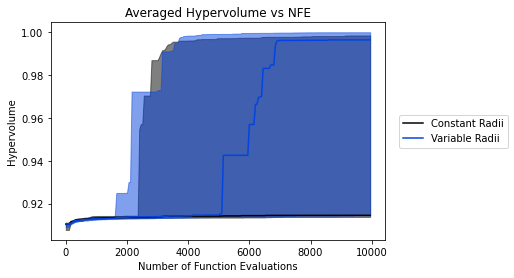

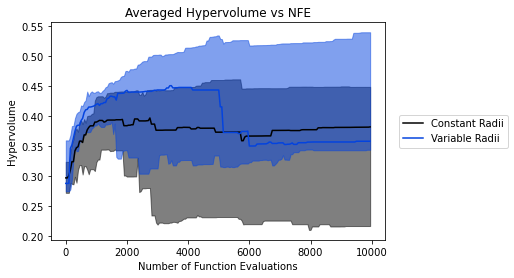

In [11]:
np.set_printoptions(threshold=np.inf)
fibre_stiffness = False
optimization_prob2_bool = True # boolean to read optimization problem2 data
constant_rad_data_read = False # Read constant radii problem data
sidenum = 3 # 3x3 node grid
cases_dict = {}
num_runs = 30 # number of runs for each case

# bools = [int_pen_partcoll, AOS_partcoll, bias_init_partcoll, ACH_partcoll, int_pen_nodalprop, AOS_nodalprop, bias_init_nodalprop, ACH_nodalprop, int_pen_orient, AOS_orient, bias_init_orient, ACH_orient, fibre_stiffness, with_norm]
case1_bools = [False, False, False, False, False, False, False, False, False, False, False, False, fibre_stiffness, constant_rad_data_read] # Simple E-MOEA, Constant Radii problem
case2_bools = [False, False, False, False, False, False, False, False, False, False, False, False, fibre_stiffness, not constant_rad_data_read] # Simple E-MOEA, Variable Radii problem
cases_dict['case1'] = case1_bools
cases_dict['case2'] = case2_bools

line_colours = ['xkcd:black','xkcd:blue']
casenames = ['Constant Radii','Variable Radii']
alpha_values = [0.5,0.5] # change based on number of cases/visibility

hypervolume_computation_all_cases(fibre_stiffness, cases_dict, optimization_prob2_bool, sidenum, num_runs, line_colours, alpha_values, casenames)

In [ ]:
%debug